In [ ]:
import pandas as pd
import kagglehub
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# İhtiyacınız olan veriyi indirin
path = kagglehub.dataset_download("daniilmiheev/top-spotify-podcasts-daily-updated")
print(f"Path to dataset files: {path}")

# İndirilen klasördeki CSV dosyasını bulun ve yükleyin
# 'top_podcasts.csv' dosyasını varsayıyoruz.
csv_file = os.path.join(path, "top_podcasts.csv")

try:
    df = pd.read_csv(csv_file)
    print("\n✅ Veri seti başarıyla yüklendi.")
except FileNotFoundError:
    print(f"\n❌ Hata: {csv_file} bulunamadı. Dosya adını/yolunu kontrol edin.")
    # Örnek çalışmaya devam etmek için boş bir DataFrame oluşturup çıkıyoruz.
    df = pd.DataFrame()

if df.empty:
    exit() # Veri yüklenmediyse script'i sonlandır.

# --- Veri Önizleme ve Hazırlık ---
# NLP için kullanacağımız sütunları seçelim.
# X = Metin verisi (Episode Adı veya Açıklama)
# Y = Hedef etiket (Show Adı veya Tür)

# Print the columns to identify the correct show name column
print("DataFrame columns:", df.columns)

# Basit bir sınıflandırma görevi için, 'show.name' alanı en çok tekrar eden ilk 10 programı seçelim.
# Assuming the correct column name is 'show.name' based on the dataframe preview
top_shows = df['show.name'].value_counts().nlargest(10).index
df_filtered = df[df['show.name'].isin(top_shows)].copy()

# NLP Metni olarak 'description' sütununu kullanalım ve NaN değerleri temizleyelim.
df_filtered.dropna(subset=['description', 'show.name'], inplace=True)

X = df_filtered['description'] # Giriş Metni
y = df_filtered['show.name']    # Hedef Sınıf (Tahmin edilecek program adı)

print(f"Toplam veri boyutu (Filtrelenmiş): {len(df_filtered)}")
print(f"Sınıf Sayısı: {len(y.unique())}")

Path to dataset files: /root/.cache/kagglehub/datasets/daniilmiheev/top-spotify-podcasts-daily-updated/versions/57


/tmp/ipython-input-3987726391.py:21: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)



✅ Veri seti başarıyla yüklendi.
DataFrame columns: Index(['date', 'rank', 'region', 'chartRankMove', 'episodeUri', 'showUri',
       'episodeName', 'description', 'show.name', 'show.description',
       'show.publisher', 'duration_ms', 'explicit', 'languages',
       'release_date', 'release_date_precision', 'show.media_type',
       'show.total_episodes'],
      dtype='object')
Toplam veri boyutu (Filtrelenmiş): 13210
Sınıf Sayısı: 10


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# En çok geçen 5000 kelimeyi (özelliği) kullanalım
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Eğitim verisi üzerinde fit yapıp, hem eğitim hem test verisine transform uygulayalım
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("\n✅ Metin vektörleştirme (TF-IDF) tamamlandı.")
print(f"Özellik Sayısı (Kelime Sayısı): {X_train_vec.shape[1]}")


✅ Metin vektörleştirme (TF-IDF) tamamlandı.
Özellik Sayısı (Kelime Sayısı): 5000


In [ ]:
## 🚀 Naive Bayes Modeli
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Tahmin ve Değerlendirme
y_pred_nb = nb_model.predict(X_test_vec)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print("\n--- Naive Bayes Modeli ---")
print(f"Doğruluk Oranı (Accuracy): {accuracy_nb:.4f}")
print("\nSınıflandırma Raporu (Classification Report):\n",
      classification_report(y_test, y_pred_nb, zero_division=0))


--- Naive Bayes Modeli ---
Doğruluk Oranı (Accuracy): 0.9974

Sınıflandırma Raporu (Classification Report):
                                          precision    recall  f1-score   support

                         Call Her Daddy       0.99      1.00      0.99       264
                           Crime Junkie       1.00      1.00      1.00       204
      El Podcast de Marian Rojas Estapé       1.00      1.00      1.00       175
                    Global News Podcast       1.00      1.00      1.00       297
                    Relatos de la Noche       1.00      0.98      0.99       191
                           Rotten Mango       1.00      1.00      1.00       252
                              The Daily       1.00      0.99      0.99       233
The Diary Of A CEO with Steven Bartlett       0.99      1.00      0.99       290
               The Joe Rogan Experience       1.00      1.00      1.00       531
          This Past Weekend w/ Theo Von       1.00      1.00      1.00       20

In [ ]:
## 🚀 Logistic Regression Modeli
# Çoğu sınıflandırma problemi için 'saga' çözücüsü ve l2 regülarizasyonu iyi çalışır.
lr_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_vec, y_train)

# Tahmin ve Değerlendirme
y_pred_lr = lr_model.predict(X_test_vec)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print("\n--- Lojistik Regresyon Modeli ---")
print(f"Doğruluk Oranı (Accuracy): {accuracy_lr:.4f}")
print("\nSınıflandırma Raporu (Classification Report):\n",
      classification_report(y_test, y_pred_lr, zero_division=0))


--- Lojistik Regresyon Modeli ---
Doğruluk Oranı (Accuracy): 1.0000

Sınıflandırma Raporu (Classification Report):
                                          precision    recall  f1-score   support

                         Call Her Daddy       1.00      1.00      1.00       264
                           Crime Junkie       1.00      1.00      1.00       204
      El Podcast de Marian Rojas Estapé       1.00      1.00      1.00       175
                    Global News Podcast       1.00      1.00      1.00       297
                    Relatos de la Noche       1.00      1.00      1.00       191
                           Rotten Mango       1.00      1.00      1.00       252
                              The Daily       1.00      1.00      1.00       233
The Diary Of A CEO with Steven Bartlett       1.00      1.00      1.00       290
               The Joe Rogan Experience       1.00      1.00      1.00       531
          This Past Weekend w/ Theo Von       1.00      1.00      1.00  

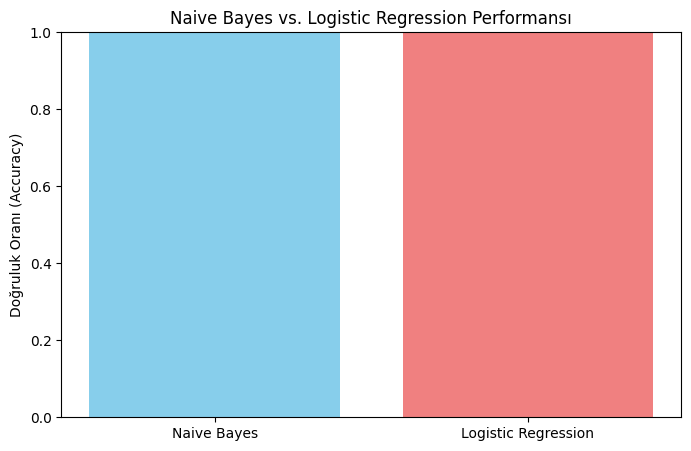

In [ ]:
# Sonuçları görselleştirelim
models = ['Naive Bayes', 'Logistic Regression']
accuracies = [accuracy_nb, accuracy_lr]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.title('Naive Bayes vs. Logistic Regression Performansı')
plt.ylabel('Doğruluk Oranı (Accuracy)')
plt.ylim(0.0, 1.0)
plt.show()

In [ ]:
pip install nltk gensim

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

In [ ]:
# Gerekli NLTK kaynaklarını indir
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Veri Ön İşleme İçin Sınıf ve Metin Belirleme
top_shows = df['show.name'].value_counts().nlargest(10).index
df_filtered = df[df['show.name'].isin(top_shows)].copy()
df_filtered.dropna(subset=['description', 'show.name'], inplace=True)
X = df_filtered['description']
y = df_filtered['show.name']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [ ]:
df

,date,rank,region,chartRankMove,episodeUri,showUri,episodeName,description,show.name,show.description,show.publisher,duration_ms,explicit,languages,release_date,release_date_precision,show.media_type,show.total_episodes
0,2024-09-02,1,us,UNCHANGED,37kBZRr3nqjltQXt8KuiDJ,4rOoJ6Egrf8K2IrywzwOMk,#2197 - Mike Baker,Mike Baker is a former CIA covert operations o...,The Joe Rogan Experience,The official podcast of comedian Joe Rogan.,Joe Rogan,9872105.0,True,['en'],2024-08-29,day,mixed,2366.0
1,2024-09-02,2,us,UNCHANGED,293KKxbEKt2zrem6XFCxYG,4rOoJ6Egrf8K2IrywzwOMk,#2195 - Andrew Huberman,"Andrew Huberman, PhD, is a neuroscientist and ...",The Joe Rogan Experience,The official podcast of comedian Joe Rogan.,Joe Rogan,11250345.0,True,['en'],2024-08-27,day,mixed,2366.0
2,2024-09-02,3,us,UNCHANGED,53z4LvgoGjjVkdiJkCGhZX,4rOoJ6Egrf8K2IrywzwOMk,#2196 - Greg Fitzsimmons,"Greg Fitzsimmons is a comedian, actor, and wri...",The Joe Rogan Experience,The official podcast of comedian Joe Rogan.,Joe Rogan,10840020.0,True,['en'],2024-08-28,day,mixed,2366.0
3,2024-09-02,4,us,UP,5rrRkpfKZUUR85WxMYCX9k,0KvuZJgXfOGanBRuq6B9dm,The Worst Creature To Run Into During The Ice Age,The Ice Age was no doubt one of earth’s most q...,ExtinctZoo,"Your one stop shop for all things dinosaurs, p...",ExtinctZoo,1073386.0,False,['en'],2024-08-31,day,mixed,30.0
4,2024-09-02,5,us,DOWN,2Qd2dJDDAocbTjGvXwHOfm,5L2ON33kXa2b7laBpCAgOI,"Jeffrey Sachs: Trump’s Plan to Stop WWIII, CIA...",Professor Jeffrey Sachs’s provides a full and ...,The Tucker Carlson Show,The Tucker Carlson Show is your beacon of free...,Tucker Carlson Network,8896992.0,False,['en'],2024-08-30,day,audio,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329995,2025-11-01,196,us,DOWN,37v6uAZmuHGMi9v9Lb5XNT,1z20EiwuKoDiftKxMVLde1,Mariska Hargitay,Mariska Hargitay never gets tired of a bit. Am...,Good Hang with Amy Poehler,Come hang with Amy Poehler. Each week on her p...,The Ringer,3818645.0,False,['en'],2025-10-21,day,mixed,35.0
329996,2025-11-01,197,us,DOWN,4R9E3GDVhUUM9vBmGiMc1M,6kCMPmQxqL1gO0DNtqeyQl,239: Simply Supernatural..,"Two Hot Takes host, Morgan, is joined by guest...",Two Hot Takes,Join host Morgan Absher and her team of co-hos...,Two Hot Takes,7820522.0,False,['en'],2025-10-23,day,mixed,248.0
329997,2025-11-01,198,us,DOWN,0x2UFs2g2r7B6LRkAZUVXg,6HdheEH8WeMTHoe5da34qU,"332: Kohberger Hits Back, Woman Escapes Captiv...",This week on Headline Highlights: new updates ...,Serialously with Annie Elise,"Serialously is hosted by Annie Elise, best kno...",Annie Elise & Audioboom Studios,1967376.0,False,['en'],2025-10-30,day,mixed,332.0
329998,2025-11-01,199,us,NEW,40GeP7MqJXM8UZStNRTkqU,3TdABllOVzlzharkEdaiWg,Ep. 1847 - What No One Noticed About Sydney Sw...,"Sydney Sweeney shows off the ""Power of Women,""...",The Michael Knowles Show,Bask in the simple joys of being right. The Mi...,The Michael Knowles Show,2964330.0,False,['en'],2025-10-31,day,mixed,2243.0


In [ ]:
# --- 2. GELİŞMİŞ METİN ÖN İŞLEME FONKSİYONU ---
print("\n--- 2. GELİŞMİŞ METİN ÖN İŞLEME (CLEANING & LEMMATIZATION) ---")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    # 1. Özel Karakter ve Sayı Temizliği
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # 2. Küçük Harfe Çevirme
    text = text.lower()
    # 3. Tokenize etme ve Kök Bulma (Lemmatization)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

# Metin Ön İşleme Uygulama
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

print("✅ Metin ön işleme ve lemmatization tamamlandı.")


--- 2. GELİŞMİŞ METİN ÖN İŞLEME (CLEANING & LEMMATIZATION) ---
✅ Metin ön işleme ve lemmatization tamamlandı.


In [ ]:
from datetime import datetime
import numpy as np

results = []

# --- A. MODEL 1: Naive Bayes (İyileştirilmiş Ön İşleme + TF-IDF) ---
print("\n--- 3.A. MODEL 1: NAIVE BAYES (TF-IDF + İyileştirilmiş Ön İşleme) ---")
start_time_nb = datetime.now()

vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_processed)
X_test_tfidf = vectorizer_tfidf.transform(X_test_processed)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
end_time_nb = datetime.now()

results.append({
    'Model': 'Naive Bayes (TF-IDF)',
    'Accuracy': accuracy_nb,
    'Time': (end_time_nb - start_time_nb).total_seconds()
})
print(f"➡️ Accuracy: {accuracy_nb:.4f}, Süre: {results[-1]['Time']:.2f}s")


# --- B. MODEL 2: Logistic Regression (İyileştirilmiş Ön İşleme + TF-IDF) ---
print("\n--- 3.B. MODEL 2: LOJİSTİK REGRESYON (TF-IDF + İyileştirilmiş Ön İşleme) ---")
start_time_lr_tfidf = datetime.now()

lr_model_tfidf = LogisticRegression(solver='saga', max_iter=2000, random_state=42, n_jobs=-1)
lr_model_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_model_tfidf.predict(X_test_tfidf)
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)
end_time_lr_tfidf = datetime.now()

results.append({
    'Model': 'LogReg (TF-IDF)',
    'Accuracy': accuracy_lr_tfidf,
    'Time': (end_time_lr_tfidf - start_time_lr_tfidf).total_seconds()
})
print(f"➡️ Accuracy: {accuracy_lr_tfidf:.4f}, Süre: {results[-1]['Time']:.2f}s")


# --- C. MODEL 3: Logistic Regression (Word2Vec + Averaged Word Vectors) ---
print("\n--- 3.C. MODEL 3: LOJİSTİK REGRESYON (WORD2VEC) ---")
start_time_w2v = datetime.now()

# 1. Word2Vec Modelini Eğitme
tokenized_text = [doc.split() for doc in X_train_processed]
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=5, workers=4)

# 2. Doküman Vektörlerini (Averaged Word Vectors) Oluşturma
def document_vector(doc):
    # Doküman içindeki kelimelerin vektörlerini bul ve ortalamasını al
    words = [word for word in doc if word in w2v_model.wv.key_to_index]
    if not words:
        return np.zeros(w2v_model.vector_size)
    return np.mean(w2v_model.wv[words], axis=0)

# Eğitim ve Test verileri için vektörleri oluştur
X_train_w2v = np.array([document_vector(doc.split()) for doc in X_train_processed])
X_test_w2v = np.array([document_vector(doc.split()) for doc in X_test_processed])

# 3. Lojistik Regresyonu Yoğun Vektörlerle Eğitme
lr_model_w2v = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1)
lr_model_w2v.fit(X_train_w2v, y_train)
y_pred_lr_w2v = lr_model_w2v.predict(X_test_w2v)
accuracy_lr_w2v = accuracy_score(y_test, y_pred_lr_w2v)
end_time_w2v = datetime.now()

results.append({
    'Model': 'LogReg (Word2Vec)',
    'Accuracy': accuracy_lr_w2v,
    'Time': (end_time_w2v - start_time_w2v).total_seconds()
})
print(f"➡️ Accuracy: {accuracy_lr_w2v:.4f}, Süre: {results[-1]['Time']:.2f}s")
print("\nLogReg (Word2Vec) Sınıflandırma Raporu:\n",
      classification_report(y_test, y_pred_lr_w2v, zero_division=0))


--- 3.A. MODEL 1: NAIVE BAYES (TF-IDF + İyileştirilmiş Ön İşleme) ---
➡️ Accuracy: 0.9974, Süre: 1.24s

--- 3.B. MODEL 2: LOJİSTİK REGRESYON (TF-IDF + İyileştirilmiş Ön İşleme) ---
➡️ Accuracy: 1.0000, Süre: 5.29s

--- 3.C. MODEL 3: LOJİSTİK REGRESYON (WORD2VEC) ---
➡️ Accuracy: 1.0000, Süre: 26.04s

LogReg (Word2Vec) Sınıflandırma Raporu:
                                          precision    recall  f1-score   support

                         Call Her Daddy       1.00      1.00      1.00       264
                           Crime Junkie       1.00      1.00      1.00       204
      El Podcast de Marian Rojas Estapé       1.00      1.00      1.00       175
                    Global News Podcast       1.00      1.00      1.00       297
                    Relatos de la Noche       1.00      1.00      1.00       191
                           Rotten Mango       1.00      1.00      1.00       252
                              The Daily       1.00      1.00      1.00       233
The Dia


--- 4. TÜM MODEL PERFORMANS KARŞILAŞTIRMASI ---
                  Model Accuracy    Time
0  Naive Bayes (TF-IDF)   0.9974   1.24s
1       LogReg (TF-IDF)   1.0000   5.29s
2     LogReg (Word2Vec)   1.0000  26.04s


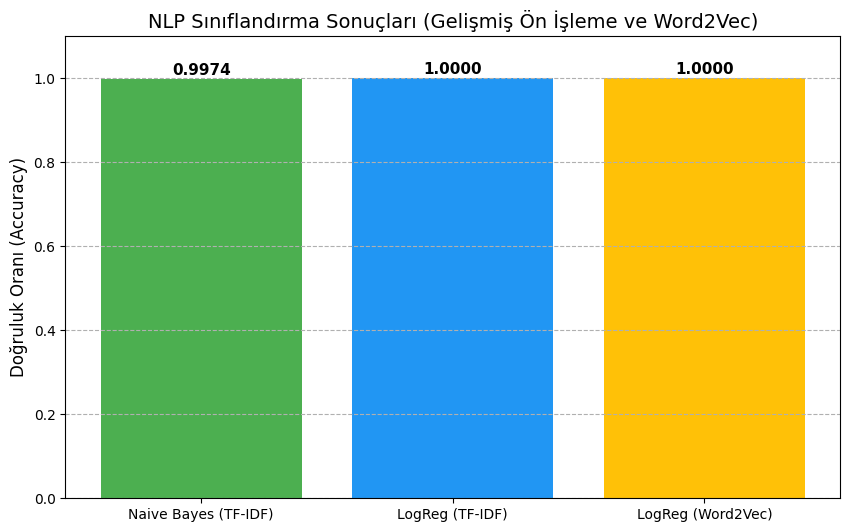

In [ ]:
# --- 4. SONUÇLARIN KARŞILAŞTIRILMASI ---
print("\n--- 4. TÜM MODEL PERFORMANS KARŞILAŞTIRMASI ---")

results_df = pd.DataFrame(results)
results_df['Accuracy'] = results_df['Accuracy'].apply(lambda x: f"{x:.4f}")
results_df['Time'] = results_df['Time'].apply(lambda x: f"{x:.2f}s")

print(results_df)

# Grafik ile gösterim
accuracies_float = [float(re.findall(r'\d+\.\d+', acc)[0]) for acc in results_df['Accuracy']]
model_names = results_df['Model']

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies_float, color=['#4CAF50', '#2196F3', '#FFC107'])
plt.title('NLP Sınıflandırma Sonuçları (Gelişmiş Ön İşleme ve Word2Vec)', fontsize=14)
plt.ylabel('Doğruluk Oranı (Accuracy)', fontsize=12)
plt.ylim(0.0, max(accuracies_float) + 0.1)
plt.grid(axis='y', linestyle='--')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Veri ön işleme ve eğitim/test seti hazırlığından sonra bu kodları ekleyin (X_train_processed, y_train mevcut olmalı)

# Naive Bayes için Pipeline
text_clf_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

# Lojistik Regresyon için Pipeline
text_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    # Uzun sürebileceği için max_iter artırıldı.
    ('lr', LogisticRegression(random_state=42, n_jobs=-1, solver='saga', max_iter=2000)),
])

In [ ]:
# Naive Bayes (NB) için Parametre Uzayı
parameters_nb = {
    # TfidfVectorizer parametreleri
    'tfidf__max_features': [5000, 8000],          # En iyi performans için dene
    'tfidf__ngram_range': [(1, 1), (1, 2)],    # Unigram veya Unigram+Bigram
    'tfidf__min_df': [1, 3],                   # Minimum doküman frekansı
    # MultinomialNB parametresi
    'nb__alpha': [0.1, 0.5, 1.0],              # Düzgünleştirme (smoothing)
}

# Lojistik Regresyon (LR) için Parametre Uzayı
parameters_lr = {
    # TfidfVectorizer parametreleri
    'tfidf__max_features': [5000, 10000],
    'tfidf__ngram_range': [(1, 2)],
    # LogisticRegression parametreleri
    'lr__C': [0.5, 1, 5],                      # Regülarizasyon gücü
    'lr__penalty': ['l2', 'l1'],               # Regülarizasyon türü
}

In [ ]:
from datetime import datetime
from sklearn.metrics import accuracy_score, classification_report

# --- A. NAIVE BAYES OPTİMİZASYONU ---
print("--- NAIVE BAYES OPTİMİZASYONU BAŞLIYOR (GRID SEARCH) ---")
start_time_nb_opt = datetime.now()

grid_search_nb = GridSearchCV(
    text_clf_nb,
    parameters_nb,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
grid_search_nb.fit(X_train_processed, y_train)
end_time_nb_opt = datetime.now()

print(f"🚀 NB En İyi Skor (Eğitim Seti): {grid_search_nb.best_score_:.4f}")
print(f"⭐ NB En İyi Parametreler: {grid_search_nb.best_params_}")

# NB Test Sonucu
y_pred_nb_opt = grid_search_nb.predict(X_test_processed)
accuracy_nb_opt = accuracy_score(y_test, y_pred_nb_opt)
print(f"\n**Naive Bayes (Optimize Edilmiş) Test Doğruluğu:** {accuracy_nb_opt:.4f}")
print("Sınıflandırma Raporu (NB):\n", classification_report(y_test, y_pred_nb_opt, zero_division=0))


# --- B. LOJİSTİK REGRESYON OPTİMİZASYONU ---
print("\n--- LOJİSTİK REGRESYON OPTİMİZASYONU BAŞLIYOR (GRID SEARCH) ---")
start_time_lr_opt = datetime.now()

grid_search_lr = GridSearchCV(
    text_clf_lr,
    parameters_lr,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
grid_search_lr.fit(X_train_processed, y_train)
end_time_lr_opt = datetime.now()

print(f"🚀 LR En İyi Skor (Eğitim Seti): {grid_search_lr.best_score_:.4f}")
print(f"⭐ LR En İyi Parametreler: {grid_search_lr.best_params_}")

# LR Test Sonucu
y_pred_lr_opt = grid_search_lr.predict(X_test_processed)
accuracy_lr_opt = accuracy_score(y_test, y_pred_lr_opt)
print(f"\n**Lojistik Regresyon (Optimize Edilmiş) Test Doğruluğu:** {accuracy_lr_opt:.4f}")
print("Sınıflandırma Raporu (LR):\n", classification_report(y_test, y_pred_lr_opt, zero_division=0))

--- NAIVE BAYES OPTİMİZASYONU BAŞLIYOR (GRID SEARCH) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
🚀 NB En İyi Skor (Eğitim Seti): 0.9981
⭐ NB En İyi Parametreler: {'nb__alpha': 0.1, 'tfidf__max_features': 8000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

**Naive Bayes (Optimize Edilmiş) Test Doğruluğu:** 0.9985
Sınıflandırma Raporu (NB):
                                          precision    recall  f1-score   support

                         Call Her Daddy       0.99      1.00      0.99       264
                           Crime Junkie       1.00      1.00      1.00       204
      El Podcast de Marian Rojas Estapé       1.00      1.00      1.00       175
                    Global News Podcast       1.00      1.00      1.00       297
                    Relatos de la Noche       1.00      0.98      0.99       191
                           Rotten Mango       1.00      1.00      1.00       252
                              The Daily       1.00      1.00   

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
import numpy as np
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Not: X_train_processed, X_test_processed, y_train, y_test değişkenlerinin
# önceki adımlardan yüklü ve temizlenmiş olduğunu varsayıyoruz.

# --- 1. PIPELINE OLUŞTURMA (Önceki Adımlardan) ---
text_clf_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB()),
])

text_clf_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42, n_jobs=-1, solver='saga', max_iter=2000)),
])


# --- 2. HİPERPARAMETRE UZAYLARINI TANIMLAMA ---

# A. Naive Bayes için Parametre Uzayı
parameters_nb = {
    'tfidf__max_features': [3000, 5000, 8000, 12000],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__min_df': [1, 3, 5],
    'nb__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
}

# B. Lojistik Regresyon için Parametre Uzayı
parameters_lr = {
    'tfidf__max_features': [5000, 10000, 15000],
    'tfidf__ngram_range': [(1, 2), (1, 3)],
    'lr__C': np.logspace(-3, 1, 10), # 0.001'den 10'a kadar logaritmik aralıkta 10 değer
    'lr__penalty': ['l2', 'l1'],
}

# --- 3. OPTİMİZASYON (RANDOMIZED SEARCH) ---
N_ITER = 50 # Denenecek rastgele kombinasyon sayısı

print(f"\n--- 3.A. NAIVE BAYES OPTİMİZASYONU BAŞLIYOR (RANDOMIZED SEARCH - {N_ITER} ITERASYON) ---")
start_time_nb_opt = datetime.now()

# Naive Bayes Randomized Search
random_search_nb = RandomizedSearchCV(
    text_clf_nb,
    parameters_nb,
    n_iter=N_ITER, # Denenecek toplam kombinasyon sayısı
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
random_search_nb.fit(X_train_processed, y_train)
end_time_nb_opt = datetime.now()

print(f"Naive Bayes Optimizasyon Süresi: {(end_time_nb_opt - start_time_nb_opt).total_seconds():.2f} saniye")
print(f"🚀 Naive Bayes En İyi Skor (Eğitim Seti): {random_search_nb.best_score_:.4f}")
print(f"⭐ Naive Bayes En İyi Parametreler: {random_search_nb.best_params_}")


print(f"\n--- 3.B. LOJİSTİK REGRESYON OPTİMİZASYONU BAŞLIYOR (RANDOMIZED SEARCH - {N_ITER} ITERASYON) ---")
start_time_lr_opt = datetime.now()

# Lojistik Regresyon Randomized Search
random_search_lr = RandomizedSearchCV(
    text_clf_lr,
    parameters_lr,
    n_iter=N_ITER, # Denenecek toplam kombinasyon sayısı
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
random_search_lr.fit(X_train_processed, y_train)
end_time_lr_opt = datetime.now()

print(f"Lojistik Regresyon Optimizasyon Süresi: {(end_time_lr_opt - start_time_lr_opt).total_seconds():.2f} saniye")
print(f"🚀 Lojistik Regresyon En İyi Skor (Eğitim Seti): {random_search_lr.best_score_:.4f}")
print(f"⭐ Lojistik Regresyon En İyi Parametreler: {random_search_lr.best_params_}")


# --- 4. OPTİMİZE EDİLMİŞ MODELLERİN TEST EDİLMESİ ---
print("\n--- 4. OPTİMİZE EDİLMİŞ MODELLERİN TEST PERFORMANSI ---")

# Naive Bayes Test Sonucu
y_pred_nb_opt = random_search_nb.predict(X_test_processed)
accuracy_nb_opt = accuracy_score(y_test, y_pred_nb_opt)
print(f"**Naive Bayes (Random Search) Test Doğruluğu:** {accuracy_nb_opt:.4f}")


# Lojistik Regresyon Test Sonucu
y_pred_lr_opt = random_search_lr.predict(X_test_processed)
accuracy_lr_opt = accuracy_score(y_test, y_pred_lr_opt)
print(f"**Lojistik Regresyon (Random Search) Test Doğruluğu:** {accuracy_lr_opt:.4f}")


--- 3.A. NAIVE BAYES OPTİMİZASYONU BAŞLIYOR (RANDOMIZED SEARCH - 50 ITERASYON) ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [ ]:
pip install tensorflow

--- 1. VERİYİ DERİN ÖĞRENMEYE HAZIRLAMA (TOKENIZATION & PADDING) ---
✅ Hazırlık Tamamlandı. Girdi şekli: (10568, 150)
✅ Çıktı sınıf sayısı: 10

--- 2. LSTM MODELİNİ OLUŞTURMA VE EĞİTME ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 84s 125ms/step - accuracy: 0.3509 - loss: 1.9011 - val_accuracy: 0.6149 - val_loss: 1.0930
Epoch 2/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.5730 - loss: 1.1079 - val_accuracy: 0.7588 - val_loss: 0.6626
Epoch 3/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.6790 - loss: 0.8223 - val_accuracy: 0.7654 - val_loss: 0.5453
Epoch 4/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.7511 - loss: 0.6082 - val_accuracy: 0.7692 - val_loss: 0.5081
Epoch 5/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 35s 117ms/step - accuracy: 0.7655 - loss: 0.5551 - val_accuracy: 0.7711 - val_loss: 0.4915
Epoch 6/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 42s 122ms/step - accuracy: 0.7732 - loss: 0.5485 - val_accuracy: 0.7729 - val_loss: 0.4812
Epoch 7/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 40s 119ms/step - accuracy: 0.7787 - loss: 0.5139 - val_accuracy: 0.7871 - val_loss: 0.4650
Epoch 8/10
298/298 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - accuracy: 0.7846 - loss: 0

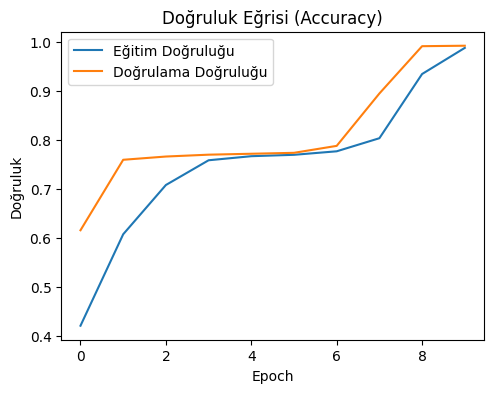

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

# Not: X_train_processed, X_test_processed, y_train, y_test değişkenlerinin
# önceki adımlardan yüklü ve temizlenmiş olduğunu varsayıyoruz.

# --- 1. VERİYİ DERİN ÖĞRENMEYE HAZIRLAMA ---
print("--- 1. VERİYİ DERİN ÖĞRENMEYE HAZIRLAMA (TOKENIZATION & PADDING) ---")

# a) Sınıf Etiketlerini Sayısallaştırma (One-Hot Encoding)
# LSTM'in çıkışı için kategorik format gerekiyor.
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)
num_classes = y_train_cat.shape[1]

# b) Metni Tokenize Etme
MAX_WORDS = 10000  # Kelime dağarcığı boyutu
MAX_LEN = 150      # Cümlelerin sabitleneceği maksimum uzunluk

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(X_train_processed)

# c) Sıraları Tam Sayı Dizilerine Dönüştürme
X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# d) Sıraları Doldurma (Padding)
# Tüm dizilerin MAX_LEN uzunluğunda olması sağlanır (genellikle sona sıfır eklenir)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"✅ Hazırlık Tamamlandı. Girdi şekli: {X_train_pad.shape}")
print(f"✅ Çıktı sınıf sayısı: {num_classes}")

# --- 2. LSTM MODELİNİ OLUŞTURMA ---
print("\n--- 2. LSTM MODELİNİ OLUŞTURMA VE EĞİTME ---")

EMBEDDING_DIM = 128 # Kelime vektörlerinin boyutu

model = Sequential([
    # 1. Embedding Katmanı: Kelimeleri yoğun vektörlere dönüştürür
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),

    # 2. LSTM Katmanı: Metnin sırasını ve bağlamını öğrenir
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),

    # 3. Dropout Katmanı: Aşırı öğrenmeyi (Overfitting) engeller
    Dropout(0.5),

    # 4. Çıkış Katmanı: Sınıflandırma (softmax, multiclass için)
    Dense(num_classes, activation='softmax')
])

# Modeli Derleme (Compile)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# --- 3. MODELİ EĞİTME ---
start_time_lstm = datetime.now()

history = model.fit(
    X_train_pad,
    y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.1, # Eğitim verisinin %10'unu doğrulama için kullan
    verbose=1
)

end_time_lstm = datetime.now()
print(f"\n✅ LSTM Eğitim Süresi: {(end_time_lstm - start_time_lstm).total_seconds():.2f} saniye")


# --- 4. MODELİ DEĞERLENDİRME ---
print("\n--- 4. LSTM MODELİ TEST PERFORMANSI ---")

# Tahminleri al
y_pred_proba = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred_proba, axis=1) # Olasılıklardan sınıf indeksini bul

# Orijinal etiketlere geri dönüştür
y_test_labels = le.inverse_transform(y_test_encoded)
y_pred_labels = le.inverse_transform(y_pred_classes)

accuracy_lstm = accuracy_score(y_test_labels, y_pred_labels)
print(f"**LSTM Test Doğruluğu:** {accuracy_lstm:.4f}")
print("Sınıflandırma Raporu:\n",
      classification_report(y_test_labels, y_pred_labels, zero_division=0))

# Ekstra: Eğitim geçmişini görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Eğrisi (Accuracy)')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
pip install torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime

# Verinin önceki adımlardan yüklü ve temizlenmiş olduğunu varsayıyoruz (X_train_processed, y_train, vb.)
# Bu kısımda sadece simülasyon amaçlı Dummy Data (Boş Veri) oluşturulmuştur.
# Gerçek projenizde KENDİ X_train_processed ve y_train verilerinizi kullanmalısınız.

# --- 0. DUMMY DATA (Kendi gerçek verinizi kullanınız!) ---
if 'X_train_processed' not in locals():
    print("UYARI: Gerçek veri yüklenmedi. Simülasyon verisi oluşturuluyor.")
    data = {'text': ['bu bir haber podcasti', 'komik şakalar ve hikayeler', 'siyaset ve ekonomi analizi',
                     'en iyi komedi gösterisi', 'global olaylar ve yorumlar'],
            'label': ['Haber', 'Komedi', 'Haber', 'Komedi', 'Haber']}
    df = pd.DataFrame(data)
    X = df['text'].apply(lambda x: x.lower())
    y = df['label']
    X_train_processed, X_test_processed, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# --- DUMMY DATA SONU ---


# --- 1. VERİYİ PYTORCH İÇİN HAZIRLAMA ---
print("--- 1. VERİYİ PYTORCH İÇİN HAZIRLAMA ---")

# a) Sınıf Etiketlerini Sayısallaştırma
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
num_classes = len(le.classes_)

# b) Metni Tokenize Etme
MAX_WORDS = 10000
MAX_LEN = 150

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>")
tokenizer.fit_on_texts(X_train_processed)

X_train_seq = tokenizer.texts_to_sequences(X_train_processed)
X_test_seq = tokenizer.texts_to_sequences(X_test_processed)

# c) Sıraları Doldurma (Padding)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# d) PyTorch Tensörlerine Dönüştürme
X_train_tensor = torch.LongTensor(X_train_pad)
y_train_tensor = torch.LongTensor(y_train_encoded)
X_test_tensor = torch.LongTensor(X_test_pad)
y_test_tensor = torch.LongTensor(y_test_encoded)

print(f"✅ Hazırlık Tamamlandı. Eğitim Tensör şekli: {X_train_tensor.shape}")


# --- 2. PyTorch Dataset ve DataLoader ---
class TextDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

BATCH_SIZE = 64

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TextDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ DataLoader'lar hazır. Batch Boyutu: {BATCH_SIZE}")


# --- 3. GRU MODELİNİ TANIMLAMA (nn.Module) ---
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(GRUClassifier, self).__init__()

        # 1. Embedding Katmanı
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 2. GRU Katmanı
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=True,  # Çift yönlü GRU genellikle daha iyi performans verir
                          dropout=dropout,
                          batch_first=True) # Girişin şekli: (Batch, Sequence, Features)

        # 3. Fully Connected (FC) Katmanı
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # Bidirectional olduğu için hidden_dim * 2

        # 4. Dropout Katmanı
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text şekli: [batch size, seq len]

        embedded = self.dropout(self.embedding(text))
        # embedded şekli: [batch size, seq len, emb dim]

        # rnn'den sadece çıktı (output) ve son gizli durum (hidden) alıyoruz
        output, hidden = self.rnn(embedded)
        # hidden şekli (bidirectional): [n layers * 2, batch size, hidden dim]

        # Son gizli durumu (forward ve backward) birleştirip FC katmanına veriyoruz
        # En son katmanın forward ve backward gizli durumlarını kullanırız.
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # hidden şekli: [batch size, hidden dim * 2]

        # Sınıflandırma
        return self.fc(hidden)


# Hiperparametreler
VOCAB_SIZE = MAX_WORDS
EMBEDDING_DIM = 128
HIDDEN_DIM = 64
N_LAYERS = 2
DROPOUT = 0.5
OUTPUT_DIM = num_classes

model = GRUClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)

# --- 4. EĞİTİM DÖNGÜSÜ ---
print("\n--- 4. PYTORCH EĞİTİM DÖNGÜSÜ BAŞLIYOR ---")

# Modelin kullanılacağı cihazı belirleme (GPU varsa cuda, yoksa cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizasyon ve Kayıp Fonksiyonu
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

N_EPOCHS = 10

def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    model.train() # Modeli eğitim moduna ayarla

    for batch in loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad() # Gradyanları sıfırla

        predictions = model(text).squeeze(1)

        loss = criterion(predictions, labels)
        loss.backward() # Geriye yayılım

        optimizer.step() # Parametreleri güncelle

        epoch_loss += loss.item()

    return epoch_loss / len(loader)

# Eğitim Başlangıcı
start_time_gru = datetime.now()

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.4f}')

end_time_gru = datetime.now()
print(f"\n✅ GRU Eğitim Süresi: {(end_time_gru - start_time_gru).total_seconds():.2f} saniye")


# --- 5. MODELİ DEĞERLENDİRME ---
def evaluate(model, loader, criterion):
    total_loss = 0
    all_preds = []
    all_labels = []
    model.eval() # Modeli değerlendirme moduna ayarla

    with torch.no_grad():
        for batch in loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            total_loss += loss.item()

            # Tahminleri al
            predicted_classes = torch.argmax(predictions, dim=1)
            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)

    return avg_loss, all_preds, all_labels

test_loss, test_preds, test_labels = evaluate(model, test_loader, criterion)
accuracy_gru = accuracy_score(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=le.classes_, zero_division=0)

print("\n--- 5. GRU MODELİ TEST PERFORMANSI ---")
print(f"GRU Test Doğruluğu: {accuracy_gru:.4f}")
print("Sınıflandırma Raporu:\n", report)

--- 1. VERİYİ PYTORCH İÇİN HAZIRLAMA ---
✅ Hazırlık Tamamlandı. Eğitim Tensör şekli: torch.Size([10568, 150])
✅ DataLoader'lar hazır. Batch Boyutu: 64

--- 4. PYTORCH EĞİTİM DÖNGÜSÜ BAŞLIYOR ---
Epoch: 01 | Train Loss: 1.0882
Epoch: 02 | Train Loss: 0.1221
Epoch: 03 | Train Loss: 0.0372
Epoch: 04 | Train Loss: 0.0148
Epoch: 05 | Train Loss: 0.0122
Epoch: 06 | Train Loss: 0.0072
Epoch: 07 | Train Loss: 0.0054
Epoch: 08 | Train Loss: 0.0044
Epoch: 09 | Train Loss: 0.0025
Epoch: 10 | Train Loss: 0.0019

✅ GRU Eğitim Süresi: 672.13 saniye

--- 5. GRU MODELİ TEST PERFORMANSI ---
GRU Test Doğruluğu: 1.0000
Sınıflandırma Raporu:
                                          precision    recall  f1-score   support

                         Call Her Daddy       1.00      1.00      1.00       264
                           Crime Junkie       1.00      1.00      1.00       204
      El Podcast de Marian Rojas Estapé       1.00      1.00      1.00       175
                    Global News Podcast     